# VinID Data Science and Analytics Challenge

LightGBM classification model capable of measuring customers propensity to shop next month at Rainbow Store.

Algorithm Publication:
https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf

***
## Package Requirements

In [1]:
# fundamental packages

import numpy as np 
import pandas as pd

# visualization

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# lightgbm model package

import lightgbm as lgbm

# tensorflow model package

import tensorflow as tf
import tensorflow.python.keras.metrics

# keras packages

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras import backend as K
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.metrics import AUC

# sci-kit learn packages

from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.utils import class_weight

# hyperopt hyper-parameter tuning packages

import hyperopt
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin

# model interpretability

import shap

# runtime performance benchmarking

import time

# system

import warnings
warnings.filterwarnings('ignore')



## Data Preparation

In [2]:
PARTITION_SIZE = 0.3
SEED = 777

### Ingest Data Files

In [3]:
df_base = pd.read_csv('../data/model_train.csv')
df_dev = pd.read_csv('../data/model_dev.csv')
df_holdout = pd.read_csv('../data/model_holdout.csv')

df_train = pd.concat([df_base, df_dev])
df_eval = df_holdout


### Model Data

In [4]:
columns_to_remove = ['csn','ref_date','predict_month','target_class']

y = df_train['target_class']
X = df_train.drop(columns_to_remove, axis=1)

y_eval = df_eval['target_class']
X_eval = df_eval.drop(columns_to_remove, axis=1)

print('Training df shape', X.shape)
print('Test df shape', X_eval.shape)

Training df shape (28755, 28)
Test df shape (17835, 28)


In [5]:
X.head()

days_since_last_purchase  purchased_in_last_15d  purchased_in_last_30d  \
0                         2                      1                      1   
1                         2                      1                      1   
2                        24                      0                      1   
3                        18                      0                      1   
4                        16                      0                      1   

   purchased_in_last_60d  baskets_over_15d  baskets_over_30d  \
0                      1                 2                 5   
1                      1                 2                 5   
2                      1                 0                 5   
3                      1                 0                 5   
4                      1                 0                 5   

   baskets_over_60d  baskets_over_15d_30d  baskets_over_30d_60d  \
0                15                     3                    10   
1                15                     3                    10   
2                15                     5                    10   
3                15                     5                    10   
4                15                     5                    10   

   spend_amt_over_15d  ...  basket_rate_over_30d_60d  spend_rate_over_15d  \
0         44800.00000  ...                  0.333333          2986.666667   
1        737301.97334  ...                  0.333333         49153.464889   
2             0.00000  ...                  0.333333             0.000000   
3             0.00000  ...                  0.333333             0.000000   
4             0.00000  ...                  0.333333             0.000000   

   spend_rate_over_30d  spend_rate_over_60d  spend_rate_over_15d_30d  \
0         23943.333333         22689.233333             44900.000000   
1         66596.732813        111646.499910             84040.000737   
2         52069.433697         96260.433539            104138.867395   
3          7420.000000         30073.849988             14840.000000   
4         37618.066491        108859.949667             75236.132983   

   spend_rate_over_30d_60d  basket_momentum_short  basket_momentum_long  \
0             21435.133333              -0.057158             -1.179183   
1            156696.267007              -0.057158             -1.179183   
2            140451.433381              -0.287682             -1.179183   
3             52727.699976              -0.287682             -1.179183   
4            180101.832843              -0.287682             -1.179183   

   spend_momentum_short  spend_momentum_long  
0         -6.734903e+05        -6.430415e+05  
1         -1.260588e+06        -4.700875e+06  
2         -1.562084e+06        -4.213530e+06  
3         -2.226010e+05        -1.581820e+06  
4         -1.128543e+06        -5.403042e+06  

[5 rows x 28 columns]

In [6]:
X_eval.head()

days_since_last_purchase  purchased_in_last_15d  purchased_in_last_30d  \
0                        70                      0                      0   
1                       108                      0                      0   
2                        77                      0                      0   
3                        77                      0                      0   
4                        72                      0                      0   

   purchased_in_last_60d  baskets_over_15d  baskets_over_30d  \
0                      0                 0                 0   
1                      0                 0                 0   
2                      0                 0                 0   
3                      0                 0                 0   
4                      0                 0                 0   

   baskets_over_60d  baskets_over_15d_30d  baskets_over_30d_60d  \
0                 0                     0                     0   
1                 0                     0                     0   
2                 0                     0                     0   
3                 0                     0                     0   
4                 0                     0                     0   

   spend_amt_over_15d  ...  basket_rate_over_30d_60d  spend_rate_over_15d  \
0                 0.0  ...                       0.0                  0.0   
1                 0.0  ...                       0.0                  0.0   
2                 0.0  ...                       0.0                  0.0   
3                 0.0  ...                       0.0                  0.0   
4                 0.0  ...                       0.0                  0.0   

   spend_rate_over_30d  spend_rate_over_60d  spend_rate_over_15d_30d  \
0                  0.0                  0.0                      0.0   
1                  0.0                  0.0                      0.0   
2                  0.0                  0.0                      0.0   
3                  0.0                  0.0                      0.0   
4                  0.0                  0.0                      0.0   

   spend_rate_over_30d_60d  basket_momentum_short  basket_momentum_long  \
0                      0.0                    0.0                  -1.0   
1                      0.0                    0.0                  -1.0   
2                      0.0                    0.0                  -1.0   
3                      0.0                    0.0                  -1.0   
4                      0.0                    0.0                  -1.0   

   spend_momentum_short  spend_momentum_long  
0                  -1.0                 -1.0  
1                  -1.0                 -1.0  
2                  -1.0                 -1.0  
3                  -1.0                 -1.0  
4                  -1.0                 -1.0  

[5 rows x 28 columns]

In [7]:
X.describe()

days_since_last_purchase  purchased_in_last_15d  purchased_in_last_30d  \
count              28755.000000           28755.000000           28755.000000   
mean                  27.626604               0.438219               0.617354   
std                   24.253695               0.496177               0.486042   
min                    1.000000               0.000000               0.000000   
25%                    6.000000               0.000000               0.000000   
50%                   20.000000               0.000000               1.000000   
75%                   46.000000               1.000000               1.000000   
max                   88.000000               1.000000               1.000000   

       purchased_in_last_60d  baskets_over_15d  baskets_over_30d  \
count           28755.000000       28755.00000      28755.000000   
mean                0.885655           0.83655          1.735350   
std                 0.318236           1.51177          2.874046   
min                 0.000000           0.00000          0.000000   
25%                 1.000000           0.00000          0.000000   
50%                 1.000000           0.00000          1.000000   
75%                 1.000000           1.00000          2.000000   
max                 1.000000          14.00000         29.000000   

       baskets_over_60d  baskets_over_15d_30d  baskets_over_30d_60d  \
count      28755.000000          28755.000000          28755.000000   
mean           3.541541              0.898800              1.806190   
std            5.248128              1.613434              2.775721   
min            0.000000              0.000000              0.000000   
25%            1.000000              0.000000              0.000000   
50%            2.000000              0.000000              1.000000   
75%            4.000000              1.000000              2.000000   
max           58.000000             15.000000             30.000000   

       spend_amt_over_15d  ...  basket_rate_over_30d_60d  spend_rate_over_15d  \
count        2.875500e+04  ...              28755.000000         2.875500e+04   
mean         2.793178e+05  ...                  0.060206         1.862118e+04   
std          9.238569e+05  ...                  0.092524         6.159046e+04   
min          0.000000e+00  ...                  0.000000         0.000000e+00   
25%          0.000000e+00  ...                  0.000000         0.000000e+00   
50%          0.000000e+00  ...                  0.033333         0.000000e+00   
75%          2.945650e+05  ...                  0.066667         1.963767e+04   
max          9.806400e+07  ...                  1.000000         6.537600e+06   

       spend_rate_over_30d  spend_rate_over_60d  spend_rate_over_15d_30d  \
count         2.875500e+04         2.875500e+04             2.875500e+04   
mean          1.924159e+04         2.235455e+04             1.986200e+04   
std           4.363646e+04         4.055099e+04             4.493744e+04   
min           0.000000e+00         0.000000e+00             0.000000e+00   
25%           0.000000e+00         2.482317e+03             0.000000e+00   
50%           4.684500e+03         9.340267e+03             0.000000e+00   
75%           2.239527e+04         2.609054e+04             2.213460e+04   
max           3.270010e+06         2.134338e+06             1.943067e+06   

       spend_rate_over_30d_60d  basket_momentum_short  basket_momentum_long  \
count             2.875500e+04           28755.000000          28755.000000   
mean              2.546751e+04              -0.003458             -1.007457   
std               5.147294e+04               0.070936              0.065697   
min               0.000000e+00              -0.550046             -1.766667   
25%               0.000000e+00              -0.060625             -1.033333   
50%               8.184900e+03               0.000000             -1.000544   
75%               3.113928e+04               0.000000   

### Data Quality

In [8]:
X.isnull().values.any()

False

In [9]:
X_eval.isnull().values.any()

False

### Normalisation and Standardisation

Experiments reveal no apparent model performance and runtime benefits from either normalization or standardisation.

In [10]:
X.columns

Index(['days_since_last_purchase', 'purchased_in_last_15d',
       'purchased_in_last_30d', 'purchased_in_last_60d', 'baskets_over_15d',
       'baskets_over_30d', 'baskets_over_60d', 'baskets_over_15d_30d',
       'baskets_over_30d_60d', 'spend_amt_over_15d', 'spend_amt_over_30d',
       'spend_amt_over_60d', 'spend_amt_over_15d_30d',
       'spend_amt_over_30d_60d', 'basket_rate_over_15d',
       'basket_rate_over_30d', 'basket_rate_over_60d',
       'basket_rate_over_15d_30d', 'basket_rate_over_30d_60d',
       'spend_rate_over_15d', 'spend_rate_over_30d', 'spend_rate_over_60d',
       'spend_rate_over_15d_30d', 'spend_rate_over_30d_60d',
       'basket_momentum_short', 'basket_momentum_long', 'spend_momentum_short',
       'spend_momentum_long'],
      dtype='object')

In [11]:
columns_type_overflow = [
    'spend_amt_over_15d'
    , 'spend_amt_over_30d'
    , 'spend_amt_over_60d'
    , 'spend_amt_over_15d_30d'
    , 'spend_amt_over_30d_60d'
    , 'spend_rate_over_15d'
    , 'spend_rate_over_30d'
    , 'spend_rate_over_60d'
    , 'spend_rate_over_15d_30d'
    , 'spend_rate_over_30d_60d'        
    ]

for n in columns_type_overflow:
    X['log_'+n] = X.apply(lambda x: np.log(1 + x[n]), axis=1)
    X_eval['log_'+n] = X_eval.apply(lambda x: np.log(1 + x[n]), axis=1)

X = X.drop(columns_type_overflow, axis=1)
X_eval = X_eval.drop(columns_type_overflow, axis=1)

In [12]:
X.describe()

days_since_last_purchase  purchased_in_last_15d  purchased_in_last_30d  \
count              28755.000000           28755.000000           28755.000000   
mean                  27.626604               0.438219               0.617354   
std                   24.253695               0.496177               0.486042   
min                    1.000000               0.000000               0.000000   
25%                    6.000000               0.000000               0.000000   
50%                   20.000000               0.000000               1.000000   
75%                   46.000000               1.000000               1.000000   
max                   88.000000               1.000000               1.000000   

       purchased_in_last_60d  baskets_over_15d  baskets_over_30d  \
count           28755.000000       28755.00000      28755.000000   
mean                0.885655           0.83655          1.735350   
std                 0.318236           1.51177          2.874046   
min                 0.000000           0.00000          0.000000   
25%                 1.000000           0.00000          0.000000   
50%                 1.000000           0.00000          1.000000   
75%                 1.000000           1.00000          2.000000   
max                 1.000000          14.00000         29.000000   

       baskets_over_60d  baskets_over_15d_30d  baskets_over_30d_60d  \
count      28755.000000          28755.000000          28755.000000   
mean           3.541541              0.898800              1.806190   
std            5.248128              1.613434              2.775721   
min            0.000000              0.000000              0.000000   
25%            1.000000              0.000000              0.000000   
50%            2.000000              0.000000              1.000000   
75%            4.000000              1.000000              2.000000   
max           58.000000             15.000000             30.000000   

       basket_rate_over_15d  ...  log_spend_amt_over_15d  \
count          28755.000000  ...            28755.000000   
mean               0.055770  ...                5.330791   
std                0.100785  ...                6.350367   
min                0.000000  ...                0.000000   
25%                0.000000  ...                0.000000   
50%                0.000000  ...                0.000000   
75%                0.066667  ...               12.593258   
max                0.933333  ...               18.401131   

       log_spend_amt_over_30d  log_spend_amt_over_60d  \
count            28755.000000            28755.000000   
mean                 7.913742               11.826870   
std                  6.456332                4.503444   
min                  0.000000                0.000000   
25%                  0.000000               11.911299   
50%                 11.853219               13.236436   
75%                 13.417804               14.263673   
max                 18.401501               18.668012   

       log_spend_amt_over_15d_30d  log_spend_amt_over_30d_60d  \
count                28755.000000                28755.000000   
mean                     5.495561                    8.705484   
std                      6.406103                    6.381882   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.000000                   12.411248   
75%                     12.712950                   13.747424   
max                     17.187828                   18.401501   

       log_spend_rate_over_15d  log_spend_rate_over_30d  \
count             28755.000000             28755.000000   
mean                  4.201462                 5.852064   
std                   5.027782                 4.821390   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.00000

In [13]:
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X), index=X.index, columns=X.columns)
X_eval = pd.DataFrame(sc.fit_transform(X_eval), index=X_eval.index, columns=X_eval.columns)


In [14]:
X.describe()

days_since_last_purchase  purchased_in_last_15d  purchased_in_last_30d  \
count              2.875500e+04           2.875500e+04           2.875500e+04   
mean               7.116547e-17           7.907274e-18          -1.146555e-16   
std                1.000017e+00           1.000017e+00           1.000017e+00   
min               -1.097856e+00          -8.832069e-01          -1.270188e+00   
25%               -8.916984e-01          -8.832069e-01          -1.270188e+00   
50%               -3.144567e-01          -8.832069e-01           7.872849e-01   
75%                7.575636e-01           1.132237e+00           7.872849e-01   
max                2.489289e+00           1.132237e+00           7.872849e-01   

       purchased_in_last_60d  baskets_over_15d  baskets_over_30d  \
count           2.875500e+04      2.875500e+04      2.875500e+04   
mean            7.907274e-17      1.581455e-16     -2.372182e-17   
std             1.000017e+00      1.000017e+00      1.000017e+00   
min            -2.783063e+00     -5.533677e-01     -6.038111e-01   
25%             3.593164e-01     -5.533677e-01     -6.038111e-01   
50%             3.593164e-01     -5.533677e-01     -2.558634e-01   
75%             3.593164e-01      1.081201e-01      9.208421e-02   
max             3.593164e-01      8.707461e+00      9.486670e+00   

       baskets_over_60d  baskets_over_15d_30d  baskets_over_30d_60d  \
count      2.875500e+04          2.875500e+04          2.875500e+04   
mean       1.344237e-16          1.027946e-16          1.581455e-17   
std        1.000017e+00          1.000017e+00          1.000017e+00   
min       -6.748315e-01         -5.570826e-01         -6.507215e-01   
25%       -4.842840e-01         -5.570826e-01         -6.507215e-01   
50%       -2.937366e-01         -5.570826e-01         -2.904486e-01   
75%        8.735826e-02          6.272433e-02          6.982442e-02   
max        1.037692e+01          8.740021e+00          1.015747e+01   

       basket_rate_over_15d  ...  log_spend_amt_over_15d  \
count          2.875500e+04  ...            2.875500e+04   
mean           1.423309e-16  ...            1.818673e-16   
std            1.000017e+00  ...            1.000017e+00   
min           -5.533677e-01  ...           -8.394608e-01   
25%           -5.533677e-01  ...           -8.394608e-01   
50%           -5.533677e-01  ...           -8.394608e-01   
75%            1.081201e-01  ...            1.143649e+00   
max            8.707461e+00  ...            2.058238e+00   

       log_spend_amt_over_30d  log_spend_amt_over_60d  \
count            2.875500e+04            2.875500e+04   
mean             7.907274e-17            8.698002e-17   
std              1.000017e+00            1.000017e+00   
min             -1.225755e+00           -2.626229e+00   
25%             -1.225755e+00            1.874795e-02   
50%              6.101833e-01            3.130029e-01   
75%              8.525209e-01            5.411071e-01   
max              1.624443e+00            1.519117e+00   

       log_spend_amt_over_15d_30d  log_spend_amt_over_30d_60d  \
count                2.875500e+04                2.875500e+04   
mean                -1.976819e-16                4.744365e-17   
std                  1.000017e+00                1.000017e+00   
min                 -8.578783e-01               -1.364117e+00   
25%                 -8.578783e-01               -1.364117e+00   
50%                 -8.578783e-01                5.806796e-01   
75%                  1.126662e+00                7.900535e-01   
max                  1.825208e+00                1.519330e+00   

       log_spend_rate_over_15d  log_spend_rate_over_30d  \
count             2.875500e+04             2.875500e+04   
mean             -1.344237e-16            -1.700064e-16   
std               1.000017e+00             1.000017e+00   
min              -8.356638e-01            -1.213792e+00   
25%              -8.356638e-01            -1.213792e+00   
50%              -8.356638e-0

In [15]:
X = pd.DataFrame(normalize(X), index=X.index, columns=X.columns)
X_eval = pd.DataFrame(normalize(X_eval), index=X_eval.index, columns=X_eval.columns)

In [16]:
X.describe()

days_since_last_purchase  purchased_in_last_15d  purchased_in_last_30d  \
count              28755.000000           28755.000000           28755.000000   
mean                  -0.006363              -0.012573               0.001456   
std                    0.205583               0.243170               0.244604   
min                   -0.431828              -0.366328              -0.368281   
25%                   -0.179897              -0.241683              -0.307004   
50%                   -0.070744              -0.137601               0.142055   
75%                    0.206922               0.262687               0.208567   
max                    0.378511               0.499191               0.347106   

       purchased_in_last_60d  baskets_over_15d  baskets_over_30d  \
count           28755.000000      28755.000000      28755.000000   
mean                0.029321         -0.034924         -0.037429   
std                 0.167814          0.142685          0.130255   
min                -0.445946         -0.229520         -0.182956   
25%                 0.067871         -0.151727         -0.153355   
50%                 0.093781         -0.086559         -0.072409   
75%                 0.100442          0.029611          0.023818   
max                 0.158419          0.469990          0.369596   

       baskets_over_60d  baskets_over_15d_30d  baskets_over_30d_60d  \
count      28755.000000          28755.000000          28755.000000   
mean          -0.036825             -0.033949             -0.030871   
std            0.126147              0.140020              0.138022   
min           -0.146739             -0.206426             -0.199119   
25%           -0.129352             -0.150419             -0.103462   
50%           -0.102958             -0.086967             -0.081058   
75%            0.022322              0.018441              0.019766   
max            0.345210              0.466280              0.458924   

       basket_rate_over_15d  ...  log_spend_amt_over_15d  \
count          28755.000000  ...            28755.000000   
mean              -0.034924  ...               -0.016194   
std                0.142685  ...                0.235531   
min               -0.229520  ...               -0.348183   
25%               -0.151727  ...               -0.230170   
50%               -0.086559  ...               -0.131311   
75%                0.029611  ...                0.250515   
max                0.469990  ...                0.417419   

       log_spend_amt_over_30d  log_spend_amt_over_60d  \
count            28755.000000            28755.000000   
mean                -0.005215                0.018255   
std                  0.236977                0.168830   
min                 -0.371407               -0.470023   
25%                 -0.311315                0.005220   
50%                  0.132401                0.075190   
75%                  0.198570                0.119979   
max                  0.284708                0.234048   

       log_spend_amt_over_15d_30d  log_spend_amt_over_30d_60d  \
count                28755.000000                28755.000000   
mean                    -0.011279                    0.008157   
std                      0.236959                    0.229936   
min                     -0.317886                   -0.417417   
25%                     -0.231638                   -0.215782   
50%                     -0.133925                    0.131156   
75%                      0.253569                    0.193013   
max                      0.406527                    0.303609   

       log_spend_rate_over_15d  log_spend_rate_over_30d  \
count             28755.000000             28755.000000   
mean                 -0.016914                -0.007124   
std                   0.233811                 0.234242   
min                  -0.346608                -0.367782   
25%                  -0.229129                -0.308277   
50%                  -0.13071

### Collinearity

For information only. Multi-collinearity does not impact tree-based classification.



In [17]:
v = pd.concat([X, y], axis=1)
v = v.sample(n=100)

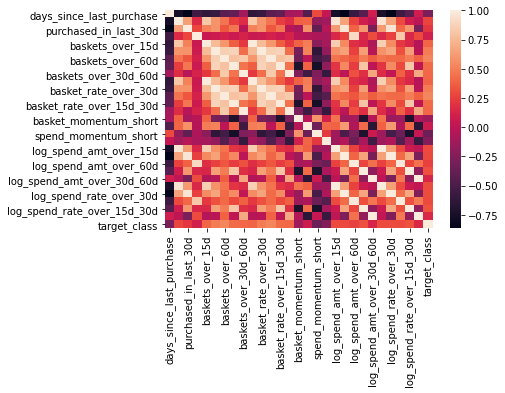

In [18]:
sns.heatmap(v.corr(), annot=False)

Identify patterns and structures with lighter colours in collinearity heat map

### Class Balance

Classes are fairly balance. No further rebalancing or class weights required.

In [24]:
def class_balance(df,target,title='Target Percentages'):

    labels = [str(x) for x in list(df['target_class'].unique())]
    values = [(len(df[df['target_class'] == 0])/len(df))*100,(len(df[df['target_class'] > 0])/len(df))*100]    
    
    trace=go.Pie(labels=labels,values=values)
    layout = go.Layout(
        title=title,
        height=400,
        margin=go.Margin(l=0, r=200, b=100, t=100, pad=4)   # Margins - Left, Right, Top Bottom, Padding
        )
    fig = go.Figure(data=[trace], layout=layout)
    fig.show()
    
    
class_balance(v,'target_class')

### Feature Distributions

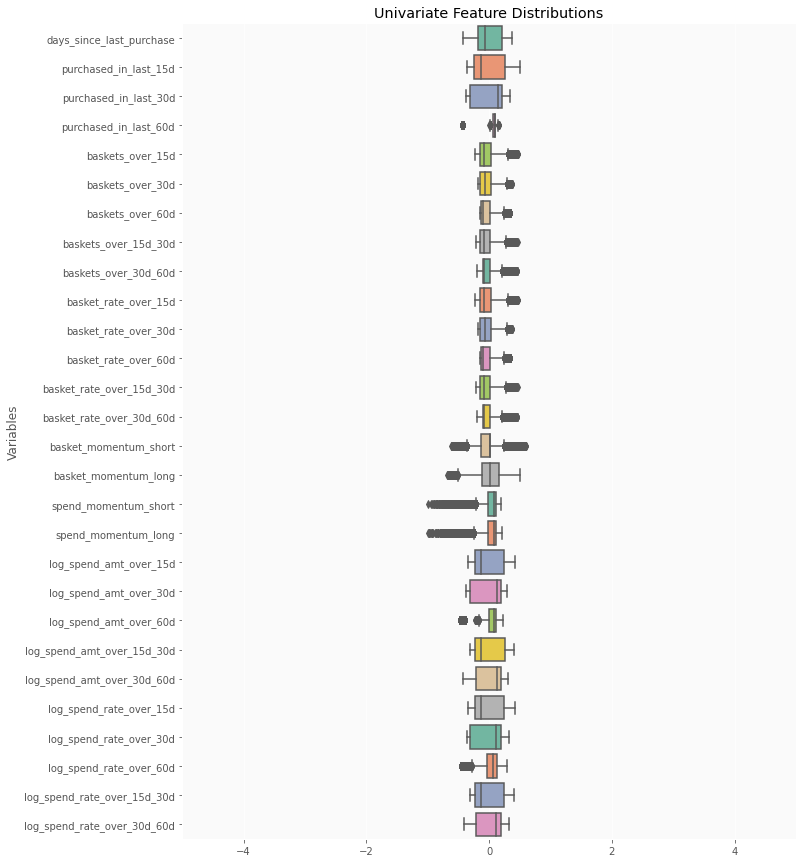

In [25]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-5, 5))
plt.ylabel('Variables')
plt.title("Univariate Feature Distributions")
ax = sns.boxplot(data = X, 
  orient = 'h', 
  palette = 'Set2')

In [26]:
def plot_distribution(df,feature,target) : 
    figsize = (15, 8)
    sns.set_style("ticks")
    s = sns.FacetGrid(df, hue=target, aspect = 2.5, palette ={0 : 'red', 1 :'green'})
    s.map(sns.kdeplot, feature, shade = True, alpha = 0.3)
    s.set(xlim=(df[feature].min(), df[feature].max()))
    s.add_legend()
    s.set_axis_labels(feature, 'proportion')
    s.fig.suptitle(feature)
    plt.show()

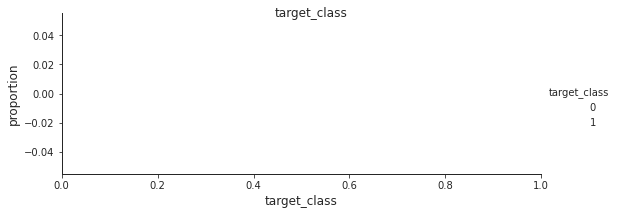

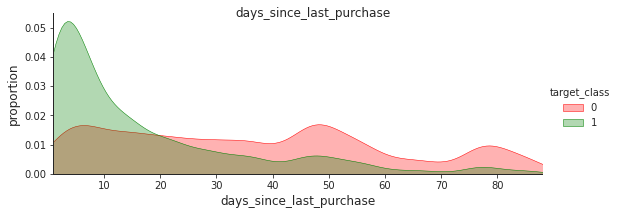

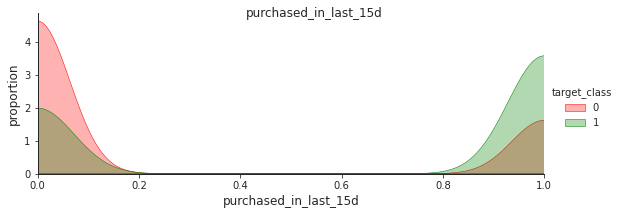

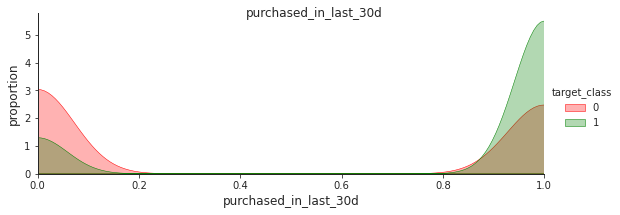

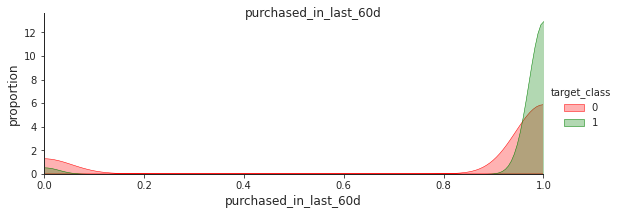

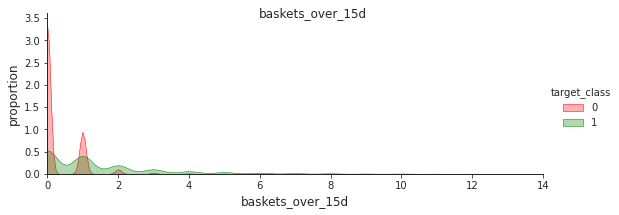

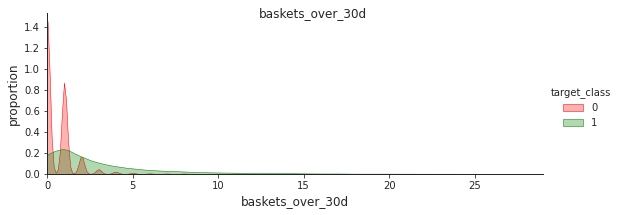

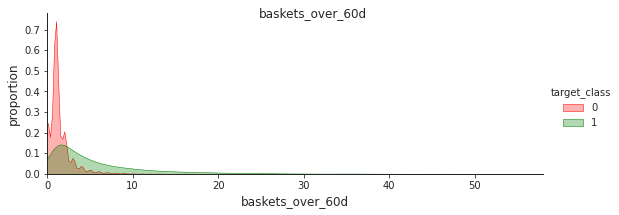

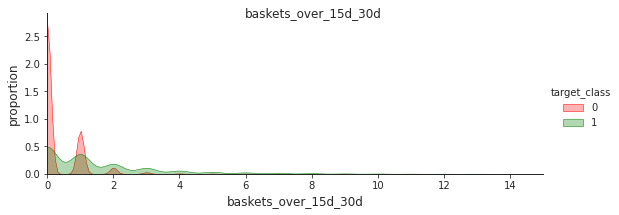

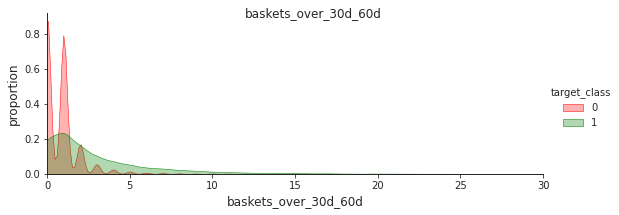

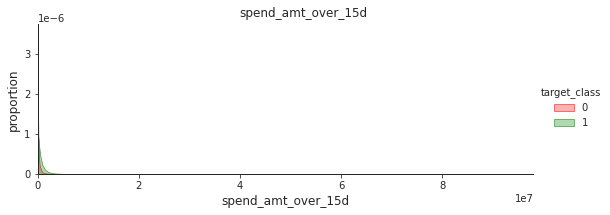

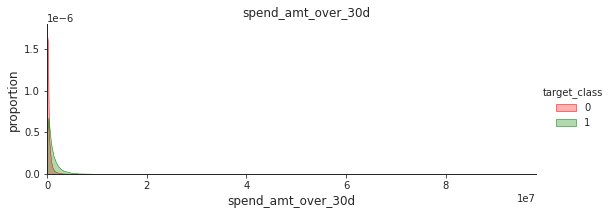

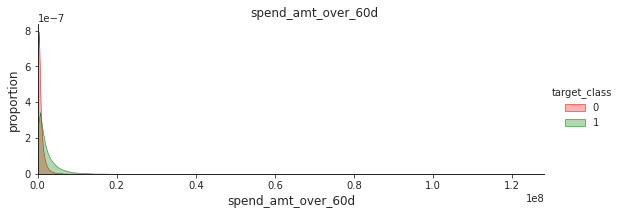

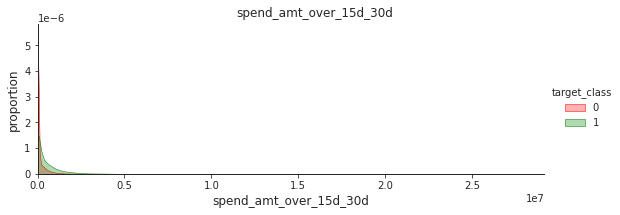

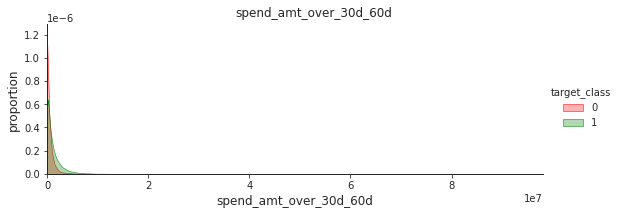

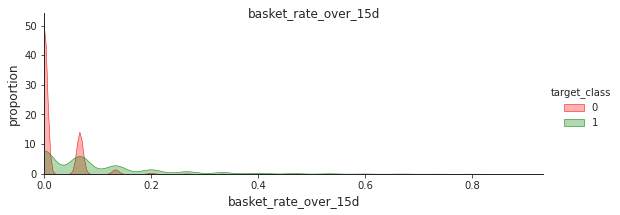

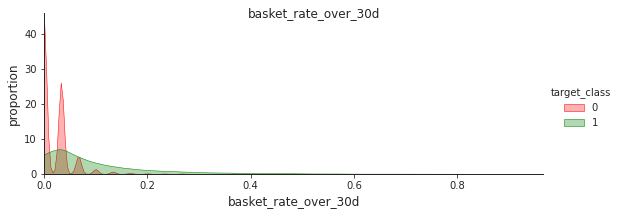

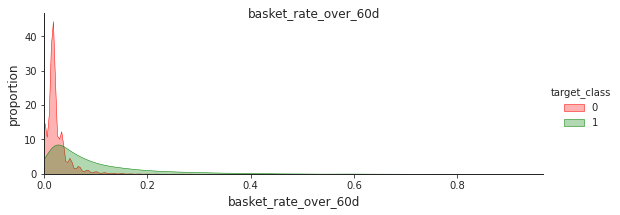

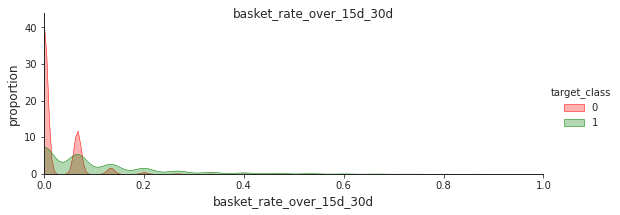

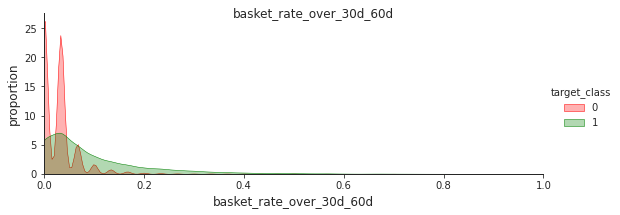

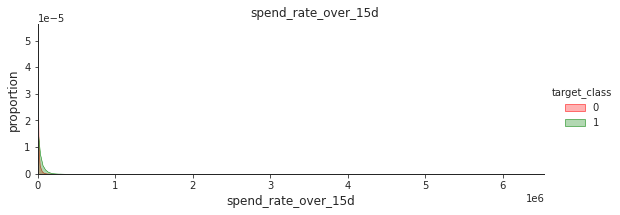

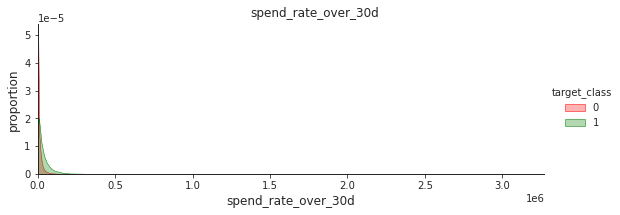

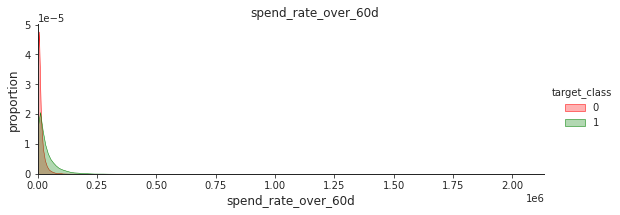

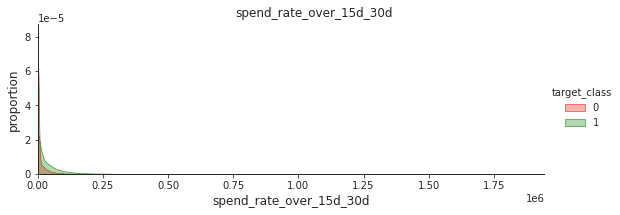

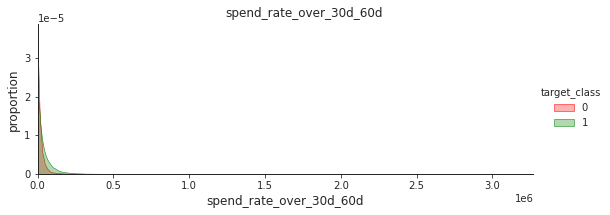

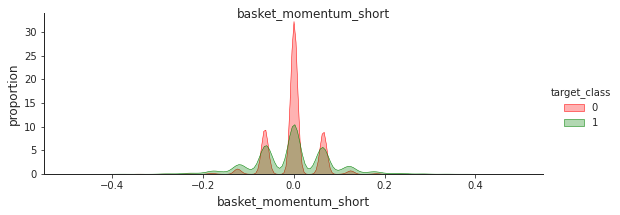

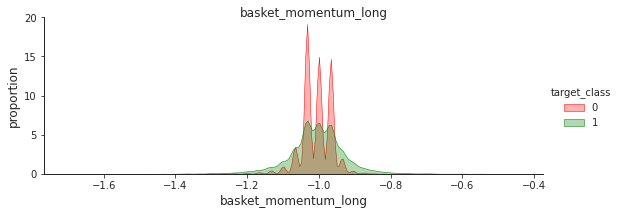

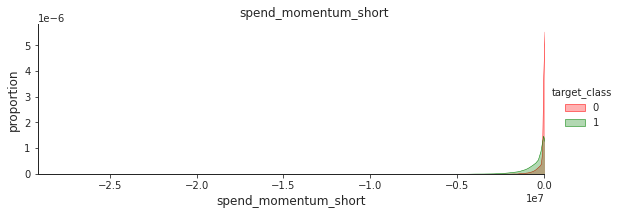

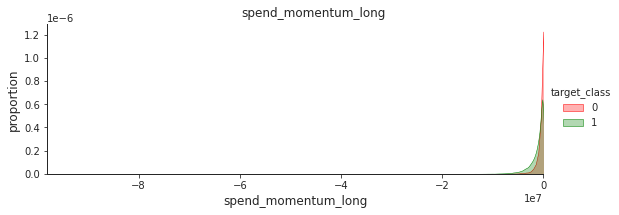

In [27]:
columns_to_remove_viz = ['csn','ref_date','predict_month']
V = df_train.drop(columns_to_remove_viz, axis=1)
for c in V.columns.values:
    plot_distribution(V,c,'target_class')

### Partitioning

Dividing the data into training and test partitions.

In [28]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=PARTITION_SIZE, random_state=SEED)

print("x_train: ", X_train.shape)
print("x_test: " , X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: " , y_test.shape)


x_train:  (20128, 28)
x_test:  (8627, 28)
y_train:  (20128,)
y_test:  (8627,)


***
## Feature Selection using LightGBM
https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf

### LightGBM Parameters

In [29]:
# dev parameters

DEBUG = False
MAX_ROWS = None
VERBOSITY = 100

# cv parameters

N_CLASSES = 2
N_FOLDS = 5
N_REPEATS = 2

# quick CV baseline parameters

MAX_BOOST_ROUNDS = 100
LEARNING_RATE = 0.002
EARLY_STOPPING = 500

# feature selection lightgbm parameters

FEATURE_SELECTION_PARAMS = {
    'boosting_type': 'gbdt',
    'bagging_freq': 10, # handling overfitting
    'bagging_fraction': 0.2, # handling overfitting - adding some noise
    # 'boost': 'dart', 
    # 'boost': 'goss',
    'boost_from_average': False,
    'boost': 'gbdt',   
    'feature_fraction': 0.15,
    'learning_rate': 0.002,
    'num_leaves': 20,
    'max_depth': 2, 
    'metric':'auc',
    'num_threads': 16,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    "bagging_seed" : 122,
    "seed": 20,
    "n_estimators": 1000,
    'min_child_samples': None,
    'subsample_for_bin': 1000,
    'min_data_in_leaf': 3
    }



In [30]:
#check if given parameter can be interpreted as a numerical value
def is_number(s):
    if s is None or type(s) is bool:
        return False
    try:
        float(s)
        return True
    except ValueError:
        return False

#convert given set of paramaters to integer values
#this at least cuts the excess float decimals if they are there
def convert_int_params(params):
    for p in params:
        if is_number(params[p]):
            if float(params[p]).is_integer():
                params[p] = str(int(params[p]))
    return params

#convert float parameters to 3 digit precision strings
#just for simpler diplay and all
def convert_float_params(params):
    for p in params:
        if is_number(params[p]):
            raw_value = float(params[p])
            if not raw_value.is_integer():
                params[p] = '{:.3f}'.format(p)
    return params

def line_separator(length=50):
    print('-' * length)
    

In [31]:
def create_fit_params(params):
    if params["objective"] == "binary":
        # https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
        fit_params = {"eval_metric": ["binary_logloss", "auc"]}
    else:
        fit_params = {"eval_metric": "multi_logloss"}

    if params['boosting_type'] == "dart":
        n_estimators = 1000
    else:
        n_estimators = 5000
        fit_params["early_stopping_rounds"] = 50

    params["n_estimators"] = n_estimators
    return fit_params

In [32]:
clean_params = convert_int_params(FEATURE_SELECTION_PARAMS)
fit_params = create_fit_params(FEATURE_SELECTION_PARAMS)

### LightGBM K-Fold CV classifier function
https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf

In [33]:
# run n_folds of cross validation on the data
def fit_cv(X, y, Z, params, plots=True, n_folds=N_FOLDS, max_n=None):

    fit_params = create_fit_params(params)    
    
    # cut the data if max_n is set    
    if max_n is not None:
        X = X[:max_n]
        y = y[:max_n]
        Z = Z[:max_n]
   
    feat_importance = pd.DataFrame()

    scores = []

    folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    # folds = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=SEED)

    oof_preds = np.zeros(X.shape[0])
    sub_preds = np.zeros(Z.shape[0])
    
    for i, (train_index, test_index) in enumerate(folds.split(X.values, y.values)):
        
        if VERBOSITY > 0:
            line_separator()
            print(f"CV Fit Fold n° {i+1}")    

        clf = lgbm.LGBMClassifier(**params)
        
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        
        clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=VERBOSITY, **fit_params)

        # debug visualization
        
        if DEBUG or plots:
            
            print('Plotting metrics recorded during training...')
            ax = lgbm.plot_metric(clf.evals_result_, metric=params['metric'])
            plt.show()

            print('Plotting feature importances...')
            ax = lgbm.plot_importance(clf, max_num_features=10)
            plt.show()
        
        # scores

        score = clf.score(X_test, y_test)
        scores.append(score)

        oof_preds[test_index] = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(Z, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
        # feature importance
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X_test.columns.values
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feat_importance = pd.concat([feat_importance, fold_importance_df], axis=0)

    # model performance

    auc = roc_auc_score(y, oof_preds)
    logloss = log_loss(y, oof_preds)

    print(f"auc: {auc:.10f} \t logloss: {logloss:.10f}")
        
    return auc, logloss, feat_importance, clf, scores, oof_preds, sub_preds


### CV Baseline

In [34]:
d_train = lgbm.Dataset(X_train,label=y_train)
cv_results = lgbm.cv(FEATURE_SELECTION_PARAMS, d_train, num_boost_round=MAX_BOOST_ROUNDS, nfold=N_FOLDS, verbose_eval=100, early_stopping_rounds=EARLY_STOPPING)

[100]	cv_agg's auc: 0.809639 + 0.00584879
[200]	cv_agg's auc: 0.81002 + 0.00591789
[300]	cv_agg's auc: 0.809913 + 0.00568995
[400]	cv_agg's auc: 0.810093 + 0.00565679
[500]	cv_agg's auc: 0.810096 + 0.00571468
[600]	cv_agg's auc: 0.810113 + 0.00565835
[700]	cv_agg's auc: 0.810183 + 0.00567895
[800]	cv_agg's auc: 0.810316 + 0.00572803
[900]	cv_agg's auc: 0.810349 + 0.00575886
[1000]	cv_agg's auc: 0.810423 + 0.00578036
[1100]	cv_agg's auc: 0.810473 + 0.00578485
[1200]	cv_agg's auc: 0.810507 + 0.00577076
[1300]	cv_agg's auc: 0.810498 + 0.00575154
[1400]	cv_agg's auc: 0.810541 + 0.00571601
[1500]	cv_agg's auc: 0.810568 + 0.00570109
[1600]	cv_agg's auc: 0.810607 + 0.0057687
[1700]	cv_agg's auc: 0.810709 + 0.00576951
[1800]	cv_agg's auc: 0.810771 + 0.00574958
[1900]	cv_agg's auc: 0.810789 + 0.00575827
[2000]	cv_agg's auc: 0.81084 + 0.00571519
[2100]	cv_agg's auc: 0.810856 + 0.00569822
[2200]	cv_agg's auc: 0.810839 + 0.00561179
[2300]	cv_agg's auc: 0.810736 + 0.00558341
[2400]	cv_agg's auc: 0.

In [35]:
print(f"Parameters:\n{clean_params}")
print(f"Baseline {clean_params['metric']} score: ", cv_results[clean_params['metric'] + '-mean'][-1])

Parameters:
{'boosting_type': 'gbdt', 'bagging_freq': '10', 'bagging_fraction': 0.2, 'boost_from_average': False, 'boost': 'gbdt', 'feature_fraction': 0.15, 'learning_rate': 0.002, 'num_leaves': '20', 'max_depth': '2', 'metric': 'auc', 'num_threads': '16', 'tree_learner': 'serial', 'objective': 'binary', 'verbosity': '1', 'bagging_seed': '122', 'seed': '20', 'n_estimators': 5000, 'min_child_samples': None, 'subsample_for_bin': '1000', 'min_data_in_leaf': '3'}
Baseline auc score:  0.8108746549584165


### K-Fold CV LightGBM Model with Feature Importance

--------------------------------------------------
CV Fit Fold n° 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.681433	valid_0's auc: 0.818488
Plotting metrics recorded during training...


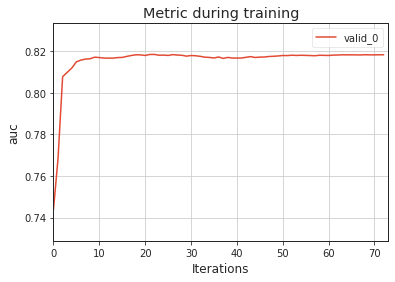

Plotting feature importances...


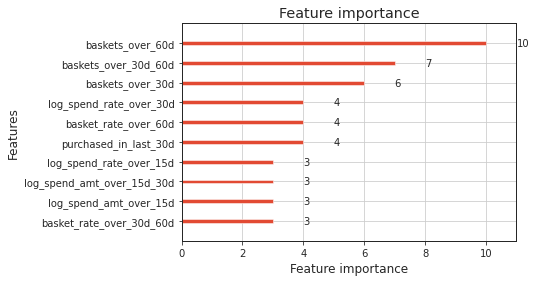

--------------------------------------------------
CV Fit Fold n° 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.683926	valid_0's auc: 0.815559
Plotting metrics recorded during training...


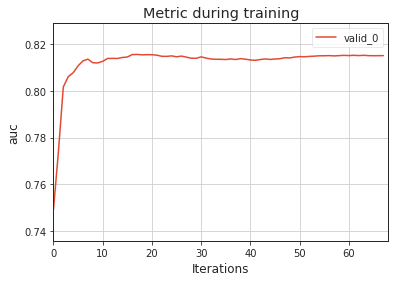

Plotting feature importances...


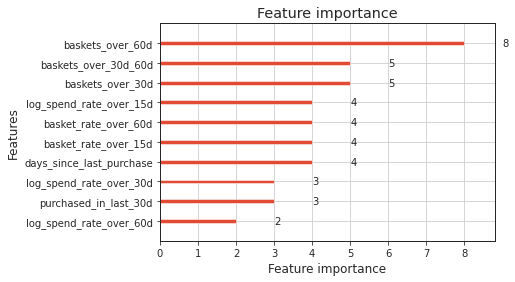

--------------------------------------------------
CV Fit Fold n° 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.677108	valid_0's auc: 0.80448
Plotting metrics recorded during training...


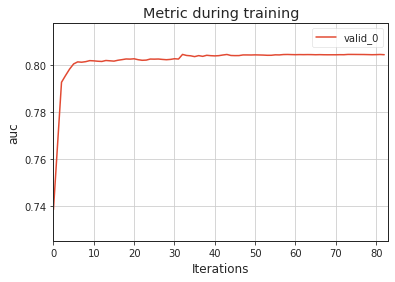

Plotting feature importances...


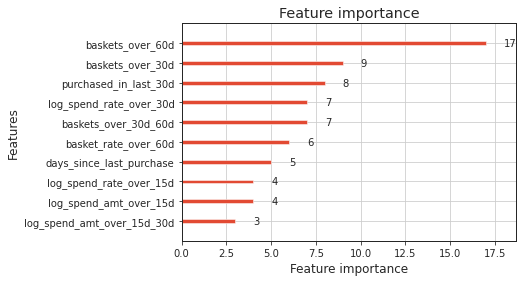

--------------------------------------------------
CV Fit Fold n° 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.682092	valid_0's auc: 0.812415
Plotting metrics recorded during training...


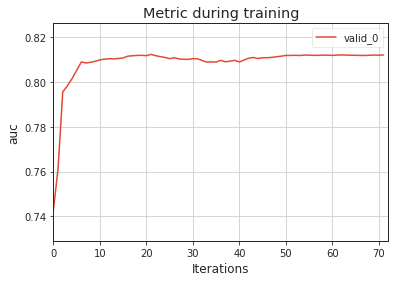

Plotting feature importances...


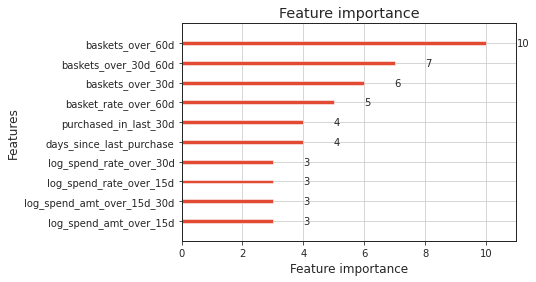

--------------------------------------------------
CV Fit Fold n° 5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.648127	valid_0's auc: 0.808683
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.662781	valid_0's auc: 0.80888
Plotting metrics recorded during training...


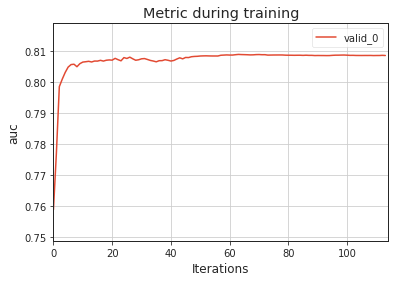

Plotting feature importances...


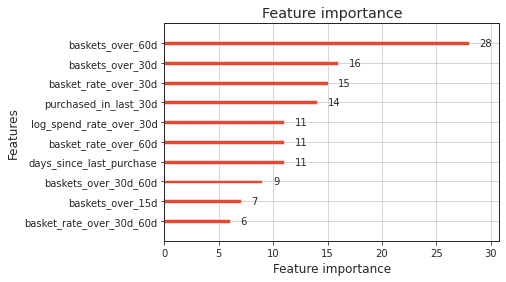

auc: 0.7979574574 	 logloss: 0.6774679487


In [36]:
auc, logloss, feat_importance, model, scores, oof_preds, sub_preds = fit_cv(X, y, X_eval, clean_params)

In [37]:
baseline_avg_score = np.mean(scores)
print(f"Mean CV {clean_params['metric']} : {baseline_avg_score:.5f}")
baseline_max_score = np.max(scores)
print(f"Max CV {clean_params['metric']} : {baseline_max_score:.5f}")
print(f"Logloss : {logloss}")

Mean CV auc : 0.75448
Max CV auc : 0.76074
Logloss : 0.6774679486910262


In [38]:
# ranking all feature by avg importance score from Kfold, select top100
all_features = feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features[0:100]['feature'])
all_features[0:100]

feature  importance
0              baskets_over_60d        14.6
1              baskets_over_30d         8.4
2          baskets_over_30d_60d         7.0
3         purchased_in_last_30d         6.6
4          basket_rate_over_60d         6.0
5       log_spend_rate_over_30d         5.6
6      days_since_last_purchase         5.4
7          basket_rate_over_30d         4.0
8       log_spend_rate_over_15d         3.8
9      basket_rate_over_30d_60d         3.2
10       log_spend_amt_over_15d         3.2
11   log_spend_amt_over_15d_30d         3.2
12         basket_rate_over_15d         3.0
13             baskets_over_15d         2.8
14         baskets_over_15d_30d         2.8
15          spend_momentum_long         2.4
16      log_spend_rate_over_60d         1.8
17       log_spend_amt_over_30d         1.8
18   log_spend_amt_over_30d_60d         1.6
19        purchased_in_last_15d         1.6
20        purchased_in_last_60d         1.4
21         basket_momentum_long         1.2
22  log_spend_rate_over_15d_30d         1.2
23     basket_rate_over_15d_30d         1.2
24       log_spend_amt_over_60d         1.0
25  log_spend_rate_over_30d_60d         0.6
26         spend_momentum_short         0.4
27        basket_momentum_short         0.2

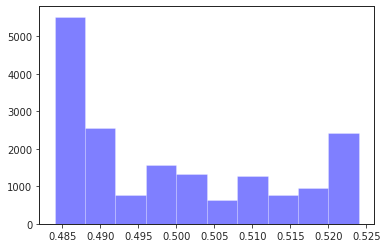

In [39]:
num_bins = 10
n, bins, patches = plt.hist(sub_preds, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [40]:
# feature importance
final_importance = feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance.reset_index(inplace=True)


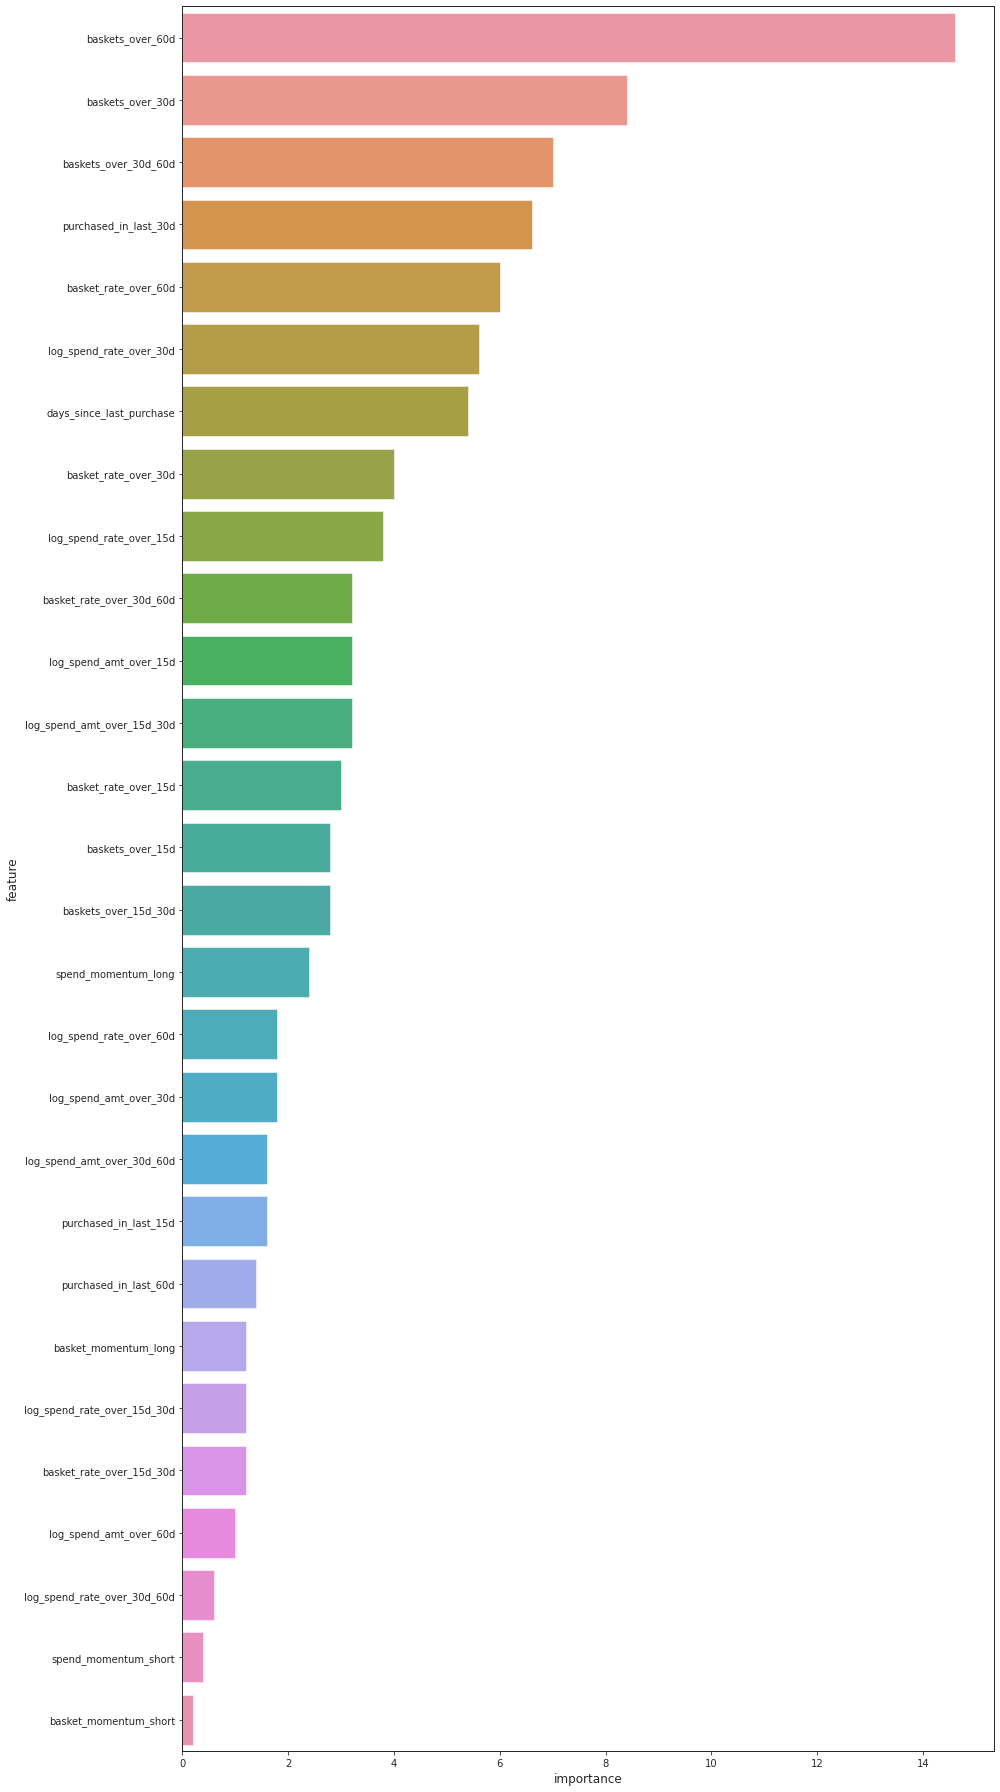

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="feature",data=final_importance)
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [43]:
FEATURE_SELECTION_CUTOFF = 9
final_importance[0:FEATURE_SELECTION_CUTOFF]

feature  importance
0          baskets_over_60d        14.6
1          baskets_over_30d         8.4
2      baskets_over_30d_60d         7.0
3     purchased_in_last_30d         6.6
4      basket_rate_over_60d         6.0
5   log_spend_rate_over_30d         5.6
6  days_since_last_purchase         5.4
7      basket_rate_over_30d         4.0
8   log_spend_rate_over_15d         3.8

In [44]:
top_features = final_importance.feature[0:FEATURE_SELECTION_CUTOFF].tolist()
top_features

['baskets_over_60d',
 'baskets_over_30d',
 'baskets_over_30d_60d',
 'purchased_in_last_30d',
 'basket_rate_over_60d',
 'log_spend_rate_over_30d',
 'days_since_last_purchase',
 'basket_rate_over_30d',
 'log_spend_rate_over_15d']

### Limiting Training Data to Top Features

In [52]:
X_backup = X.copy()
X_eval_backup = X_eval.copy()


In [54]:
X = X[top_features]
X_eval = X_eval[top_features]
X.shape

(28755, 9)

***
## Hyperparameter Tuning LightGBM with Bayesian Optimisation

Hyperparameter search with Bayesian Optimization via Tree Parzen Estimator

### Initialization

In [66]:
all_losses = []
all_params = []

### Objective function

In [67]:
def objective_sklearn(params):
    
    params = convert_int_params(params)
    fit_params = create_fit_params(params)
        
    auc, logloss, feat_importance, model, scores, oof_preds, sub_preds = fit_cv(XX, yy, ZZ, params, plots=False)

    result = {
            "status": hyperopt.STATUS_OK,
            "auc": auc,
            "loss": logloss,
            "scores": scores,
            "params": params,
            "model": model,
            "feature_importance": feat_importance,
            "training_preds": oof_preds,
            "eval_preds": sub_preds
             }
    
    return result

In [68]:
def hyperparameter_tune_lgbm(df_train, target, df_eval, n_trials, max_n_search=None):
    # https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
    # https://indico.cern.ch/event/617754/contributions/2590694/attachments/1459648/2254154/catboost_for_CMS.pdf

    space = HYPERPARAMETER_TUNING_PARAMS
    
    # globalize parameters
    
    global max_n, XX, yy, ZZ
    max_n, XX, yy, ZZ = max_n_search, df_train, target, df_eval
 
    # debug override number of trials
    
    if DEBUG:
        n_trials = 1
        
    trials = Trials()
    
    # hyperopt fmin Bayesian optimised search
    # tree-structured Parzen estimator
    # https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf
    
    best = fmin(fn=objective_sklearn,
                space=space,
                algo=tpe.suggest,
                max_evals=n_trials,
                trials=trials,
                rstate= np.random.RandomState(1),
                verbose=-1)

    # trial with lowest loss value

    idx = np.argmin(trials.losses())

    # best trial outcomes

    params = trials.trials[idx]["result"]["params"]
    model = trials.trials[idx]["result"]["model"]
    auc = trials.trials[idx]["result"]["auc"]
    logloss = trials.trials[idx]["result"]["loss"]
    
    return params, model, auc, logloss


In [69]:
N_TRIALS = 1
VERBOSITY = 0

HYPERPARAMETER_TUNING_PARAMS = {
    'objective': 'binary',
    'num_class': 1,

    'metric': 'binary_logloss',

    "n_estimators": hp.quniform('n_estimators', 1000, 10000, 1000),

    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.1),
    
    'boosting_type': 'gbdt', # hp.choice('boosting_type', ['gbdt','dart','goss'])

    'bagging_freq': 10, # handling overfitting
    'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 1), # alias "subsample"
    # 'subsample': None, # overridden by bagging_fraction    
    # 'subsample_for_bin': hp.quniform('subsample_for_bin', 1000, 10000, 10),
    
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 1),

    'boost_from_average': False,

    'class_weight': hp.choice('class_weight', [None, 'balanced']),

    'num_leaves': hp.quniform('num_leaves', 8, 256, 10),
    'max_depth': hp.quniform('max_depth', 2, 12, 10),

    # 'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 10),
    'min_sum_hessian_in_leaf': None, # overrides min_child_weight

    'min_child_samples': None, # overridden by min_data_in_leaf
    # 'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    # 'min_child_weight': hp.loguniform('min_child_weight', -16, 5), # also aliases to min_sum_hessian

    'colsample_bytree': None, # overridden by feature_fraction
    # 'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),

    # 'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
    # 'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
    'reg_alpha': None, # overridden by lambda_l1
    # 'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': None, # overridden by lambda_l2
    # 'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),

    'verbosity': -1, # fatal only

    'num_threads': 16,

    'bagging_seed' : SEED,
    'seed': SEED    
}

## Execution

In [70]:
best_params, best_model, best_auc, best_logloss = hyperparameter_tune_lgbm(X, y, X_eval, N_TRIALS)

auc: 0.8098678313 	 logloss: 0.5259068590            
100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.5259068589564291]


In [71]:
print(f"Best AUC: {best_auc}")
print(f"Best Logloss: {best_logloss}")

Best AUC: 0.809867831276223
Best Logloss: 0.5259068589564291


In [72]:
best_params

{'bagging_fraction': 0.4329568461152701,
 'bagging_freq': '10',
 'bagging_seed': '777',
 'boost_from_average': False,
 'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': None,
 'feature_fraction': 0.6204009707291966,
 'learning_rate': 0.03838279818170326,
 'max_depth': '10',
 'metric': 'binary_logloss',
 'min_child_samples': None,
 'min_sum_hessian_in_leaf': None,
 'n_estimators': 5000,
 'num_class': '1',
 'num_leaves': '70',
 'num_threads': '16',
 'objective': 'binary',
 'reg_alpha': None,
 'reg_lambda': None,
 'seed': '777',
 'verbosity': '-1'}

## Hypering the Hyper

In [62]:
hyper_results = []

In [73]:
# parameters
n_trial_initial = 1
trial_increment = 100
no_improvement_stop = 1

# initialisation
n_trial_current = n_trial_initial
no_improvement_current = 0
best_auc = 0
best_logloss = 1
auc_improvement = 0
logloss_improvement = 0

In [74]:
while no_improvement_current <= no_improvement_stop:
    
    line_separator()
    print(f"Hypertuning with {n_trial_current} trials, {no_improvement_current} no improvements")
    line_separator()
    
    params, model, auc, logloss = hyperparameter_tune_lgbm(X, y, X_eval, n_trial_current)
    
    hyper_results.append([n_trial_current, auc, logloss])
    
    auc_improvement = auc - best_auc # upwards is improvement
    logloss_improvement = best_logloss - logloss # downwards is improvement
    
    if auc_improvement > 0:
        best_auc = auc
        best_auc_params = params
    
    if logloss_improvement > 0:
        best_logloss = logloss
        best_logloss_params = params

    if auc_improvement <= 0 and logloss_improvement <= 0:
        no_improvement_current += 1

    n_trial_current += trial_increment
    
    print(f"Best AUC: {best_auc}")
    print(f"Best Logloss: {best_logloss}")

--------------------------------------------------
Hypertuning with 1 trials, 0 no improvements
--------------------------------------------------
auc: 0.8098678313 	 logloss: 0.5259068590            
100%|██████████| 1/1 [00:01<00:00,  1.68s/trial, best loss: 0.5259068589564291]
Best AUC: 0.809867831276223
Best Logloss: 0.5259068589564291
--------------------------------------------------
Hypertuning with 101 trials, 0 no improvements
--------------------------------------------------
auc: 0.8098678313 	 logloss: 0.5259068590              
auc: 0.8091842980 	 logloss: 0.5182253661                                        
auc: 0.8043032346 	 logloss: 0.5332148540                                        
auc: 0.8051034660 	 logloss: 0.5255583153                                        
auc: 0.8091239608 	 logloss: 0.5254351155                                        
auc: 0.8031859046 	 logloss: 0.5260783702                                        
auc: 0.8030590117 	 logloss: 0.5369646129  

auc: 0.8081923865 	 logloss: 0.5229019153                                         
auc: 0.8011380084 	 logloss: 0.5272704228                                         
auc: 0.8087415770 	 logloss: 0.5213217556                                         
auc: 0.8087647014 	 logloss: 0.5225564632                                         
auc: 0.8096802101 	 logloss: 0.5180189885                                         
auc: 0.8066765002 	 logloss: 0.5366273628                                         
auc: 0.8130630172 	 logloss: 0.5122315943                                         
auc: 0.8043508267 	 logloss: 0.5337409898                                          
100%|██████████| 101/101 [03:05<00:00,  1.84s/trial, best loss: 0.5095242786965405]
Best AUC: 0.8139458747554872
Best Logloss: 0.5095242786965405
--------------------------------------------------
Hypertuning with 201 trials, 0 no improvements
--------------------------------------------------
auc: 0.8098678313 	 logloss: 0.525906859

auc: 0.8094159479 	 logloss: 0.5183487808                                         
auc: 0.8114230534 	 logloss: 0.5177981565                                         
auc: 0.8088848707 	 logloss: 0.5177983242                                         
auc: 0.8092555587 	 logloss: 0.5186337803                                         
auc: 0.8041443926 	 logloss: 0.5336584263                                         
auc: 0.8081923865 	 logloss: 0.5229019153                                         
auc: 0.8011380084 	 logloss: 0.5272704228                                         
auc: 0.8087415770 	 logloss: 0.5213217556                                         
auc: 0.8087647014 	 logloss: 0.5225564632                                         
auc: 0.8096802101 	 logloss: 0.5180189885                                         
auc: 0.8066765002 	 logloss: 0.5366273628                                         
auc: 0.8130630172 	 logloss: 0.5122315943                                         
auc:

auc: 0.8008679627 	 logloss: 0.5389407434                                          
auc: 0.8064104964 	 logloss: 0.5247155401                                          
auc: 0.8089321155 	 logloss: 0.5194675920                                          
auc: 0.8060889309 	 logloss: 0.5251949803                                          
auc: 0.8135037246 	 logloss: 0.5099640924                                          
auc: 0.8030165279 	 logloss: 0.5287128683                                          
auc: 0.8117952497 	 logloss: 0.5138980899                                          
auc: 0.8135290157 	 logloss: 0.5141710621                                          
auc: 0.8065455557 	 logloss: 0.5236944810                                          
auc: 0.8054535412 	 logloss: 0.5259496321                                          
auc: 0.8101069237 	 logloss: 0.5208198516                                          
auc: 0.8060531123 	 logloss: 0.5246522167                                   

auc: 0.8136630548 	 logloss: 0.5125936564                                         
auc: 0.8047248546 	 logloss: 0.5393410319                                         
auc: 0.8056781056 	 logloss: 0.5334300102                                         
auc: 0.8129325658 	 logloss: 0.5117401573                                         
auc: 0.8098347187 	 logloss: 0.5167576664                                         
auc: 0.7993486199 	 logloss: 0.5366100003                                         
auc: 0.7993698691 	 logloss: 0.5403197344                                         
auc: 0.8124225143 	 logloss: 0.5192821191                                         
auc: 0.8055065014 	 logloss: 0.5534435249                                         
auc: 0.8094159479 	 logloss: 0.5183487808                                         
auc: 0.8114230534 	 logloss: 0.5177981565                                         
auc: 0.8088848707 	 logloss: 0.5177983242                                         
auc:

auc: 0.8135851167 	 logloss: 0.5109378162                                          
auc: 0.8081845504 	 logloss: 0.5240875655                                          
auc: 0.8104980277 	 logloss: 0.5173144587                                          
auc: 0.8132357727 	 logloss: 0.5151193642                                          
auc: 0.8051514686 	 logloss: 0.5334839562                                          
auc: 0.8023137178 	 logloss: 0.5328313439                                          
auc: 0.8134192864 	 logloss: 0.5114389493                                          
auc: 0.8134945501 	 logloss: 0.5101770125                                          
auc: 0.8077656777 	 logloss: 0.5328847476                                          
auc: 0.8008679627 	 logloss: 0.5389407434                                          
auc: 0.8064104964 	 logloss: 0.5247155401                                          
auc: 0.8089321155 	 logloss: 0.5194675920                                   

auc: 0.8101843833 	 logloss: 0.5157143764                                          
auc: 0.8134564920 	 logloss: 0.5108130304                                          
auc: 0.8135683855 	 logloss: 0.5100554835                                          
auc: 0.8139558532 	 logloss: 0.5103933497                                          
auc: 0.8095633686 	 logloss: 0.5188091579                                          
auc: 0.8135674139 	 logloss: 0.5105121163                                          
auc: 0.8057442288 	 logloss: 0.5260527056                                          
auc: 0.8025967588 	 logloss: 0.5316462907                                          
auc: 0.8051845667 	 logloss: 0.5310383551                                          
auc: 0.8134117637 	 logloss: 0.5112896111                                          
auc: 0.8136797471 	 logloss: 0.5101713733                                          
auc: 0.8028174951 	 logloss: 0.5279328536                                   

In [65]:
print(f"Best AUC: {best_auc}")
print(f"Best Logloss: {best_logloss}")


Best AUC: 0.8139458747554872
Best Logloss: 0.5094245786473186


In [75]:
best_auc_params

{'bagging_fraction': 0.8275832426856987,
 'bagging_freq': '10',
 'bagging_seed': '777',
 'boost_from_average': False,
 'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': None,
 'feature_fraction': 0.3482837876512782,
 'learning_rate': 0.07740095534963295,
 'max_depth': '0',
 'metric': 'binary_logloss',
 'min_child_samples': None,
 'min_sum_hessian_in_leaf': None,
 'n_estimators': 5000,
 'num_class': '1',
 'num_leaves': '10',
 'num_threads': '16',
 'objective': 'binary',
 'reg_alpha': None,
 'reg_lambda': None,
 'seed': '777',
 'verbosity': '-1'}

In [76]:
best_logloss_params

{'bagging_fraction': 0.8275832426856987,
 'bagging_freq': '10',
 'bagging_seed': '777',
 'boost_from_average': False,
 'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': None,
 'feature_fraction': 0.3482837876512782,
 'learning_rate': 0.07740095534963295,
 'max_depth': '0',
 'metric': 'binary_logloss',
 'min_child_samples': None,
 'min_sum_hessian_in_leaf': None,
 'n_estimators': 5000,
 'num_class': '1',
 'num_leaves': '10',
 'num_threads': '16',
 'objective': 'binary',
 'reg_alpha': None,
 'reg_lambda': None,
 'seed': '777',
 'verbosity': '-1'}

## Build Best Model using Best Parameters and All Data

In [86]:
df_train = pd.concat([df_base, df_dev])

all_y = df_train['target_class']

all_x = df_train.drop(columns_to_remove, axis=1)
all_z = df_holdout.drop(columns_to_remove, axis=1)

columns_type_overflow = [
    'spend_amt_over_15d'
    , 'spend_amt_over_30d'
    , 'spend_amt_over_60d'
    , 'spend_amt_over_15d_30d'
    , 'spend_amt_over_30d_60d'
    , 'spend_rate_over_15d'
    , 'spend_rate_over_30d'
    , 'spend_rate_over_60d'
    , 'spend_rate_over_15d_30d'
    , 'spend_rate_over_30d_60d'        
    ]

for n in columns_type_overflow:
    all_x['log_'+n] = all_x.apply(lambda x: np.log(1 + x[n]), axis=1)
    all_z['log_'+n] = all_z.apply(lambda x: np.log(1 + x[n]), axis=1)

all_x = all_x.drop(columns_type_overflow, axis=1)
all_z = all_z.drop(columns_type_overflow, axis=1)

sc = StandardScaler()

all_x = pd.DataFrame(sc.fit_transform(all_x), index=all_x.index, columns=all_x.columns)
all_z = pd.DataFrame(sc.fit_transform(all_z), index=all_z.index, columns=all_z.columns)

all_x = pd.DataFrame(normalize(all_x), index=all_x.index, columns=all_x.columns)
all_z = pd.DataFrame(normalize(all_z), index=all_z.index, columns=all_z.columns)

all_x = all_x[top_features]
all_z = all_z[top_features]

Plotting metrics recorded during training...


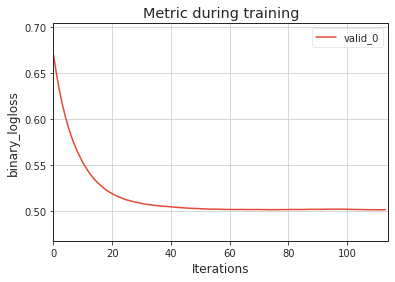

Plotting feature importances...


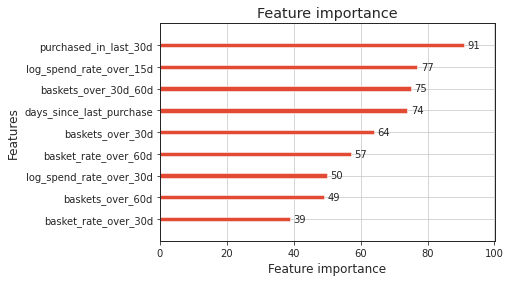

Plotting metrics recorded during training...


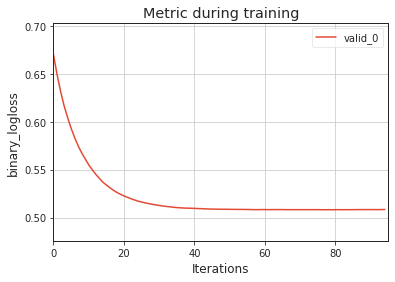

Plotting feature importances...


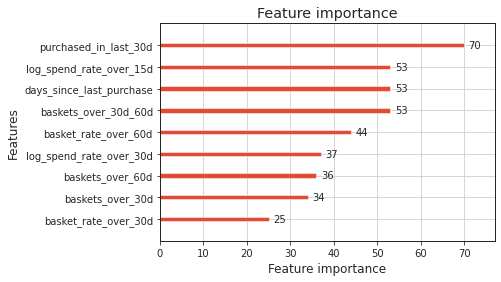

Plotting metrics recorded during training...


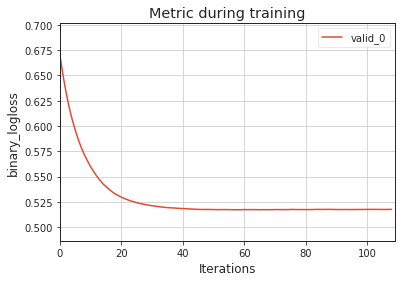

Plotting feature importances...


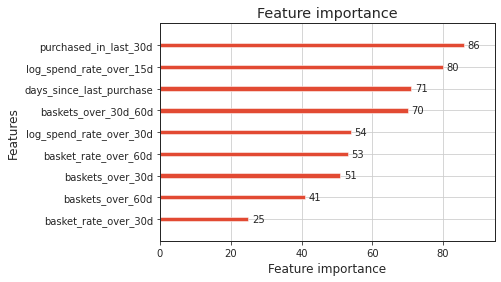

Plotting metrics recorded during training...


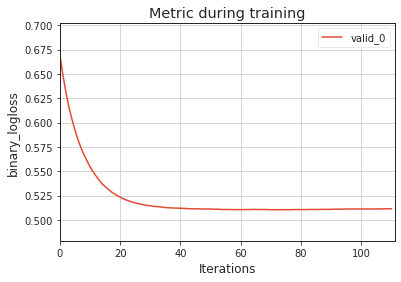

Plotting feature importances...


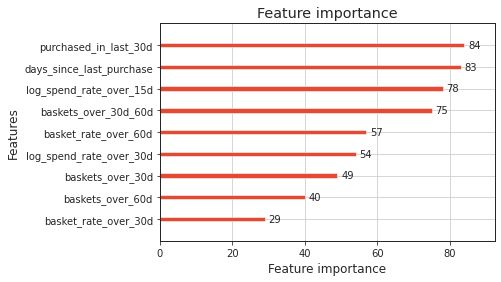

Plotting metrics recorded during training...


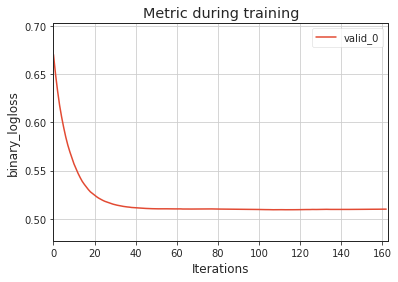

Plotting feature importances...


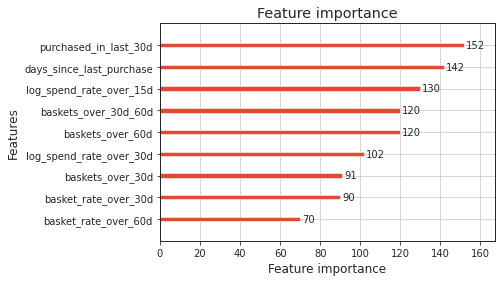

auc: 0.8139458748 	 logloss: 0.5095242787


In [87]:
best_params = best_logloss_params
auc, logloss, feat_importance, model, scores, oof_preds, sub_preds = fit_cv(all_x, all_y, all_z, best_params)

In [88]:
print(f"Best AUC: {auc}")
print(f"Best Logloss: {logloss}")


Best AUC: 0.8139458747554872
Best Logloss: 0.5095242786965405


---

## Set Thresholds

Threshold setting may require further direction from the stakeholder on business objectives to optimise on.

In [89]:
import math
fpr, tpr, thresholds = roc_curve(all_y, oof_preds)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold: %f\nGeometric Mean: %.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold: 0.439806
Geometric Mean: 0.749


---

## Model Interpretability

### Shapley

In [90]:
# load JS visualization code to notebook
shap.initjs()        


In [91]:
# Display/plot feature importance
def display_importances(feat_importance):
    best_features = feat_importance[["feature", "importance"]].groupby("feature")["importance"].agg(['mean', 'std']) \
                                                              .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean importance", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean importance", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

# Display/plot shapley values
def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM shapley values (avg over folds)')
    plt.tight_layout()
    plt.show()

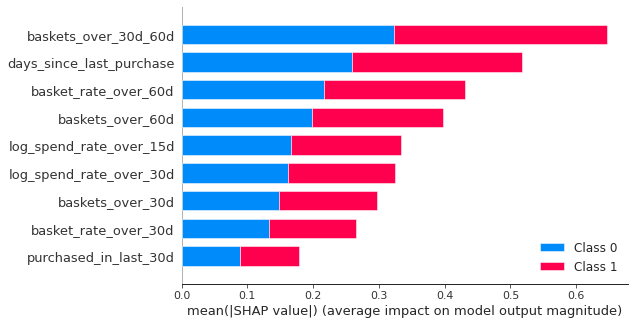

In [92]:
# summarize the effects of top features

explainer = shap.TreeExplainer(model, num_iteration=model.best_iteration_)
shap_values = explainer.shap_values(X_eval)
shap.summary_plot(shap_values, all_x, max_display=10)

### ROC and Precision Recall

In [94]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=SEED)
folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(all_x,all_y)]


In [112]:
def display_roc_curve(y_, oof_preds_,sub_preds_,folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig('roc_curve.png')



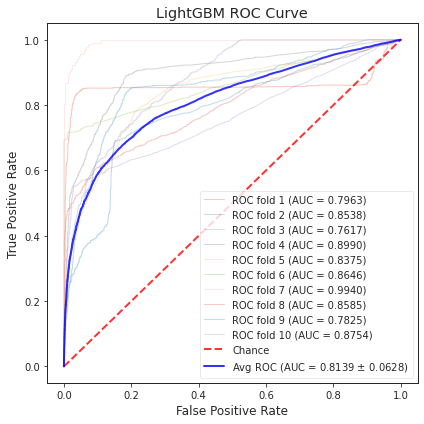

In [113]:
display_roc_curve(all_y, oof_preds, sub_preds, folds_idx)


In [123]:
def display_precision_recall(y_, oof_preds_, folds_idx_):
    
    plt.figure(figsize=(6,6))
    
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        precision, recall, thresholds = precision_recall_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        precision = np.insert(precision,0,0.0)
        recall = np.insert(recall,0,1.0)
        score = average_precision_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(recall, precision, lw=1, alpha=0.3, label='AP fold %d (PR = %0.4f)' % (n_fold + 1, score))
    
    precision, recall, thresholds = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)

    precision = np.insert(precision,0,0.0)
    recall = np.insert(recall,0,1.0)
    plt.plot(recall, precision, color='b',
             label='Avg Precision (AP = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Precision Recall Curve')
    plt.legend(loc="best")
    plt.tight_layout()

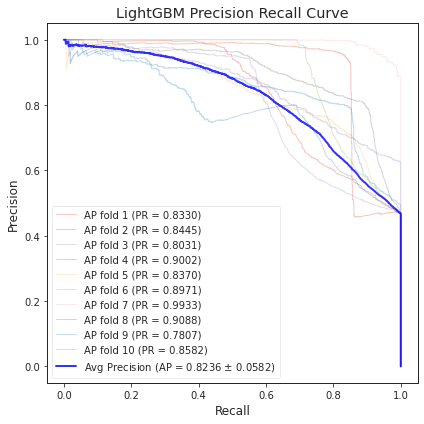

In [124]:
display_precision_recall(all_y, oof_preds, folds_idx)    